In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import clear_session
from keras.optimizers import SGD
from pathlib import Path
from keras.applications import InceptionV3
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from keras import initializers, regularizers
from datetime import datetime

In [2]:
# reusable stuff
import constants
import callbacks
import generators

In [3]:
clear_session()
print('INICIO DO PROCESSO: ', datetime.now())
# Config
height = constants.SIZES['basic']
width = height
weights_file = "weights.best_inception" + str(height) + ".hdf5"

INICIO DO PROCESSO:  2020-10-04 02:03:16.024055


In [4]:
conv_base = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(height, width, constants.NUM_CHANNELS)
)


In [5]:
conv_base.trainable = False

# Let's see it
print('Summary: ', datetime.now())
print(conv_base.summary())

[0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 17, 17, 192)  147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 17, 17, 192)  576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 17, 17, 192)  576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 17, 17, 192)  576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 17, 17, 192)  576         conv2d_69[0][0]           

In [6]:
# Let's construct that top layer replacement
x = conv_base.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x - Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(.0005))(x)
x = Dropout(0.5)(x)
# Essential to have another layer for better accuracy
x = Dense(128,activation='relu', kernel_initializer=initializers.he_normal(seed=None))(x)
x = Dropout(0.25)(x)
predictions = Dense(constants.NUM_CLASSES,  kernel_initializer="glorot_uniform", activation='softmax')(x)

In [7]:
print('Stacking New Layers ', datetime.now())
model = Model(inputs = conv_base.input, outputs=predictions)

Stacking New Layers  2020-10-04 02:03:23.753189


In [8]:
# Load checkpoint if one is found
if os.path.exists(weights_file):
        print ("loading ", weights_file)
        model.load_weights(weights_file)

In [9]:
# Get all model callbacks
callbacks_list = callbacks.make_callbacks(weights_file)

In [10]:
print('Compile model ', datetime.now())
# originally adam, but research says SGD with scheduler
# opt = Adam(lr=0.001, amsgrad=True)
opt = SGD(momentum=.9)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Compile model  2020-10-04 02:03:23.918540


In [11]:
# Get training/validation data via generators
train_generator, validation_generator = generators.create_generators(height, width)

Found 55000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [12]:
print('Start training! ', datetime.now())
history = model.fit_generator(
    train_generator,
    callbacks=callbacks_list,
    epochs=constants.TOTAL_EPOCHS,
    steps_per_epoch=constants.STEPS_PER_EPOCH,
    shuffle=True,
    workers=4,
    use_multiprocessing=False,
    validation_data=validation_generator,
    validation_steps=constants.VALIDATION_STEPS
)

Start training!  2020-10-04 02:03:26.973194
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/500 [..............................] - ETA: 0s - loss: 0.9930 - accuracy: 0.6562WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
500/500 [==============================] - 176s 352ms/step - loss: 1.1309 - accuracy: 0.5099 - val_loss: 0.9725 - val_accuracy: 0.5013
Epoch 2/100
500/500 [==============================] - 172s 345ms/step - loss: 1.0872 - accuracy: 0.5171 - val_loss: 0.9622 - val_accuracy: 0.5225
Epoch 3/100
500/500 [==============================] - 186s 372ms/step - loss: 1.0499 - accuracy: 0.5412 - val_loss: 0.9303 - val_accuracy: 0.5850
Epoch 4/100
500/500 [==============================] - 171s 342ms/step - 

In [15]:
# Save it for later
print('Saving Model ', datetime.now())
model.save("nude_classifier." + str(width) + "x" + str(height) + ".h5")
print('FINAL DO PROCESSO: ', datetime.now())

Saving Model  2020-10-04 10:01:46.362405
FINAL DO PROCESSO:  2020-10-04 10:01:48.957153


In [16]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = constants.VALIDATION_STEPS)

50/50 [==============================] - 12s 249ms/step - loss: 0.3852 - accuracy: 0.9112


In [17]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.39
Final accuracy: 91.12%


In [20]:
import matplotlib.pyplot as plt

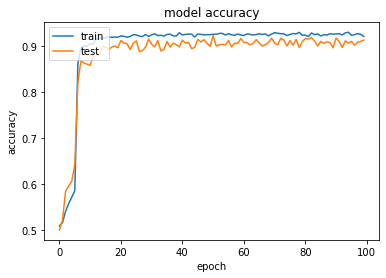

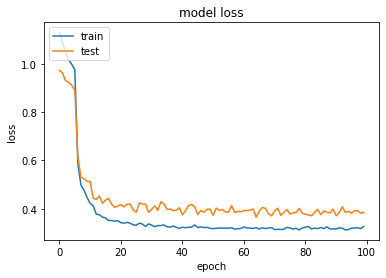

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()